In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate
import scipy.linalg

# Define system and physical parameters using values

# Masses (kg)
M_stem = 0.006      # stem_mass
M_body = 0.048      # body_mass
M_motor = 0.11233   # motor_mass
M_wheel = 0.10933   # wheel_mass

# Dimensions (m)
H_stem = 0.044      # stem_height
W_stem = 0.006      # stem_width
H_body = 0.095      # body_height
W_body = 0.054      # body_width
D_motor = 0.042     # motor diameter = 2 * motor_radius
D_wheel_out = 0.252 # wheel outer diameter = 2 * wheel_radius_out
D_wheel_in = 0.208  # wheel inner diameter = 2 * wheel_radius_in

# Motor electrical constants
k_t = 0.04          # torque_constant (N·m/A)
k_e = 0.04          # back_emf_constant (V·s/rad)
R = 0.4             # phase_resistance (ohm)
V_supply = 12.0     # supply voltage (V)

# Gravity
g = 9.81            # m/s^2

In [2]:
# Compute individual inertias about the pivot (vertical axis at base)
# Stem: treated as a rod of length H_stem, width W_stem, rotating about one end vertically
I_stem = (M_stem / 12.0) * (4 * H_stem**2 + W_stem**2)

# Body: uniform rectangular prism, COM at H_stem + H_body/2; inertia about its own COM plus parallel-axis
I_body_COM = (M_body / 12.0) * (4 * H_body**2 + W_body**2)
h_body_COM = H_stem + H_body / 2.0
I_body = I_body_COM + M_body * h_body_COM**2

# Motor: approximated as a solid cylinder of diameter D_motor, COM at top of body + D_motor/2
I_motor_COM = 0.5 * M_motor * (D_motor / 2.0) ** 2
h_motor_COM = H_stem + H_body + D_motor / 2.0
# Parallel-axis: motor inertia about pivot
I_motor = I_motor_COM + M_motor * h_motor_COM**2

# Wheel: ring (hollow cylinder) rotating about its axis; for pivot inertia, include parallel-axis
I_wheel_COM = 0.5 * M_wheel * (((D_wheel_out / 2.0) ** 2 + (D_wheel_in / 2.0) ** 2))
h_wheel_COM = h_motor_COM  # wheel COM same height as motor center
I_wheel = I_wheel_COM + M_wheel * h_wheel_COM**2

# Total inertia of pendulum assembly (including wheel, but wheel’s rotation about its own axis contributes separately in coupling)
I_tot = I_stem + I_body + I_motor + I_wheel

In [3]:
# Compute center-of-mass height d for linearized gravity torque
# Heights of COM for each component:
h_stem_COM = H_stem / 2.0
# body COM height computed above
# motor and wheel COM at same height
# Weighted average:
M_tot = M_stem + M_body + M_motor + M_wheel
d = (
    M_stem * h_stem_COM
    + M_body * h_body_COM
    + M_motor * h_motor_COM
    + M_wheel * h_wheel_COM
) / M_tot

# Display computed inertias and COM height
print("Computed values:")
print(f"I_stem = {I_stem:.4f} kg·m^2")
print(f"I_body = {I_body:.4f} kg·m^2")
print(f"I_motor = {I_motor:.4f} kg·m^2")
print(f"I_wheel = {I_wheel:.4f} kg·m^2")
print(f"I_tot (sum) = {I_tot:.4f} kg·m^2")
print(f"Center-of-mass height d = {d:.4f} m")

Computed values:
I_stem = 0.0068 kg·m^2
I_body = 0.1533 kg·m^2
I_motor = 0.0911 kg·m^2
I_wheel = 0.0610 kg·m^2
I_tot (sum) = 0.3122 kg·m^2
Center-of-mass height d = 0.3375 m


In [4]:
# Build state-space matrices A and B
# State x = [theta, theta_dot, phi, phi_dot]
# Dynamics from linearized model:
#   ddtheta = (M_tot * g * d / I_tot) * theta + (k_t * k_e / (R * I_tot)) * phi_dot - (V_supply * k_t / (R * I_tot)) * PWM * 12/V_supply
#   ddphi   = -(M_tot * g * d / I_tot) * theta - (k_t * k_e / R) * ((I_tot + I_wheel) / (I_tot * I_wheel)) * phi_dot + (V_supply * k_t / R) * ((I_tot + I_wheel) / (I_tot * I_wheel)) * PWM * 12/V_supply
# Note: the factor 12u was in torque; here V_supply * PWM = 12 * PWM, so use directly.
a21 = M_tot * g * d / I_tot
a24 = k_t * k_e / (R * I_tot)
b2 = -(V_supply * k_t) / (R * I_tot)

a43 = -M_tot * g * d / I_tot
a44 = -(k_t * k_e / R) * ((I_tot + I_wheel) / (I_tot * I_wheel))
b4 = (V_supply * k_t / R) * ((I_tot + I_wheel) / (I_tot * I_wheel))

A = np.array([[0, 1, 0, 0], [a21, 0, 0, a24], [0, 0, 0, 1], [a43, 0, 0, a44]])
B = np.array([0, b2, 0, b4]).reshape((4, 1))

print("\nState-space matrices:")
print("A =\n", A)
print("B =\n", B)


State-space matrices:
A =
 [[ 0.00000000e+00  1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.12066218e+01  0.00000000e+00  0.00000000e+00  3.66008068e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-2.12066218e+01  0.00000000e+00  0.00000000e+00 -2.23893030e-03]]
B =
 [[ 0.        ]
 [-0.10980242]
 [ 0.        ]
 [ 0.67167909]]


In [5]:
# Design LQR controller for continuous-time system
# Define weighting matrices Q and R; must be tuned per design requirements.
# Example: penalize large tilt angle and wheel speed; R small to allow actuator usage.
Q = np.diag([100.0, 1.0, 10.0, 1.0])  # tune as needed
R_mat = np.array([[1.0]])  # tune as needed

# Solve Continuous Algebraic Riccati Equation (CARE) for P
P = scipy.linalg.solve_continuous_are(A, B, Q, R_mat)
# Compute LQR gain K = R^{-1} B^T P
K = np.linalg.inv(R_mat) @ B.T @ P

print("\nLQR gain K = ", K)


LQR gain K =  [[-588.5276492  -132.00432109   -3.16227766   -4.90680712]]


In [6]:
# Simulate open-loop and closed-loop responses
def dynamics_open(t, x):
    # open-loop with zero input
    dxdt = A @ x
    return dxdt


def dynamics_closed(t, x):
    # state-feedback u = -K x
    u = -K @ x
    dxdt = A @ x + B.flatten() * u
    return dxdt


# Initial condition: small tilt, zero velocities, wheel angle zero
x0 = np.array([0.1, 0.0, 0.0, 0.0])  # 0.1 rad initial tilt

t_span = (0, 5.0)  # simulate 5 seconds
t_eval = np.linspace(t_span[0], t_span[1], 500)

# Simulate open-loop
sol_open = scipy.integrate.solve_ivp(dynamics_open, t_span, x0, t_eval=t_eval)

# Simulate closed-loop
sol_closed = scipy.integrate.solve_ivp(dynamics_closed, t_span, x0, t_eval=t_eval)

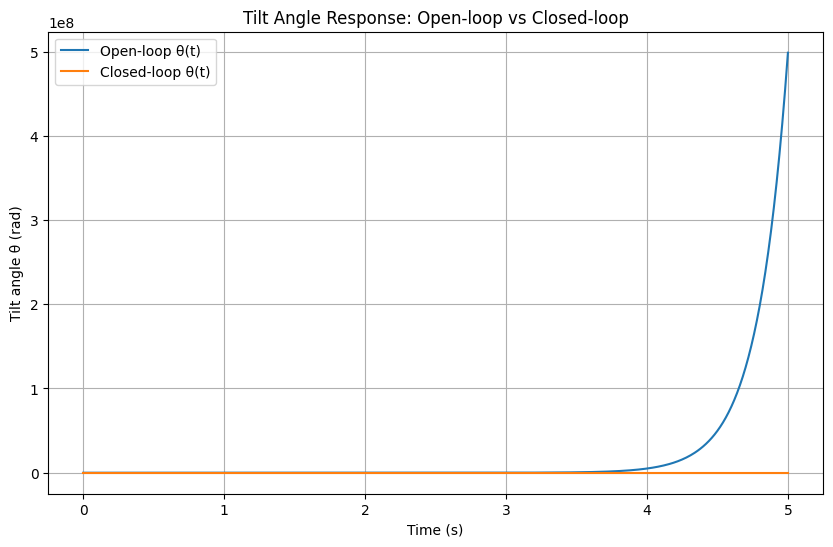

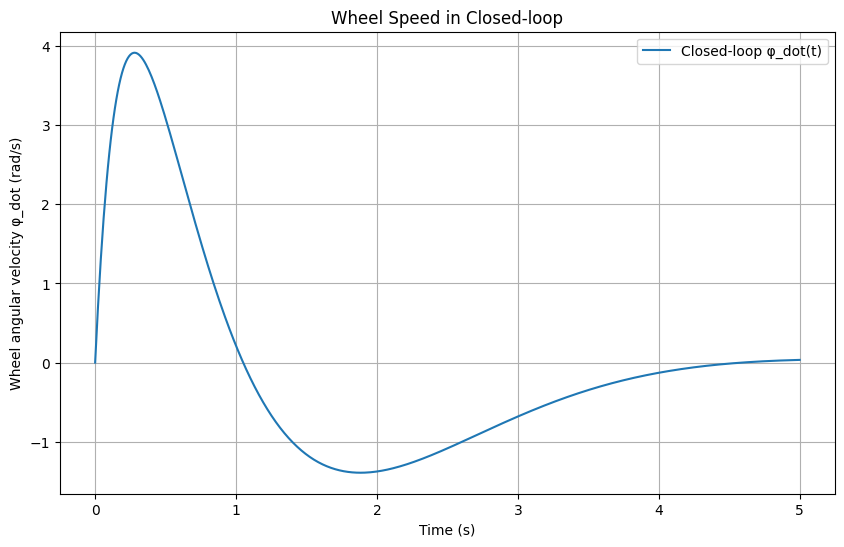

In [7]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sol_open.t, sol_open.y[0, :], label="Open-loop θ(t)")
plt.plot(sol_closed.t, sol_closed.y[0, :], label="Closed-loop θ(t)")
plt.xlabel("Time (s)")
plt.ylabel("Tilt angle θ (rad)")
plt.title("Tilt Angle Response: Open-loop vs Closed-loop")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
# Plot wheel speed in closed-loop
plt.plot(sol_closed.t, sol_closed.y[3, :], label="Closed-loop φ_dot(t)")
plt.xlabel("Time (s)")
plt.ylabel("Wheel angular velocity φ_dot (rad/s)")
plt.title("Wheel Speed in Closed-loop")
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# Discrete-time conversion (for embedded implementation)
# Choose sampling time
dt = 0.01  # 10 ms sampling
# Discretize using zero-order hold
from scipy.signal import cont2discrete

sys_cont = (A, B, np.eye(4), np.zeros((4, 1)))
sys_disc = cont2discrete(sys_cont, dt)
Ad, Bd, _, _, _ = sys_disc  # type: ignore

print("\nDiscrete-time matrices (dt = {:.3f} s):".format(dt))
print("Ad =\n", Ad)
print("Bd =\n", Bd)

# Discrete-time LQR: solve discrete-time CARE
# using scipy.linalg.solve_discrete_are
P_d = scipy.linalg.solve_discrete_are(Ad, Bd, Q, R_mat)
K_d = np.linalg.inv(Bd.T @ P_d @ Bd + R_mat) @ (Bd.T @ P_d @ Ad)  # type: ignore
print("\nDiscrete-time LQR gain K_d = ", K_d)


Discrete-time matrices (dt = 0.010 s):
Ad =
 [[ 1.00106052e+00  1.00035348e-02  0.00000000e+00  1.83035011e-08]
 [ 2.12140792e-01  1.00106052e+00  0.00000000e+00  3.66133347e-06]
 [-1.06051058e-03 -3.53479198e-06  1.00000000e+00  9.99988805e-03]
 [-2.12138805e-01 -1.06051058e-03  0.00000000e+00  9.99977610e-01]]
Bd =
 [[-5.49105034e-06]
 [-1.09840004e-03]
 [ 3.35846741e-05]
 [ 6.71710382e-03]]

Discrete-time LQR gain K_d =  [[-569.56400715 -127.67295519   -2.99007846   -4.65501332]]


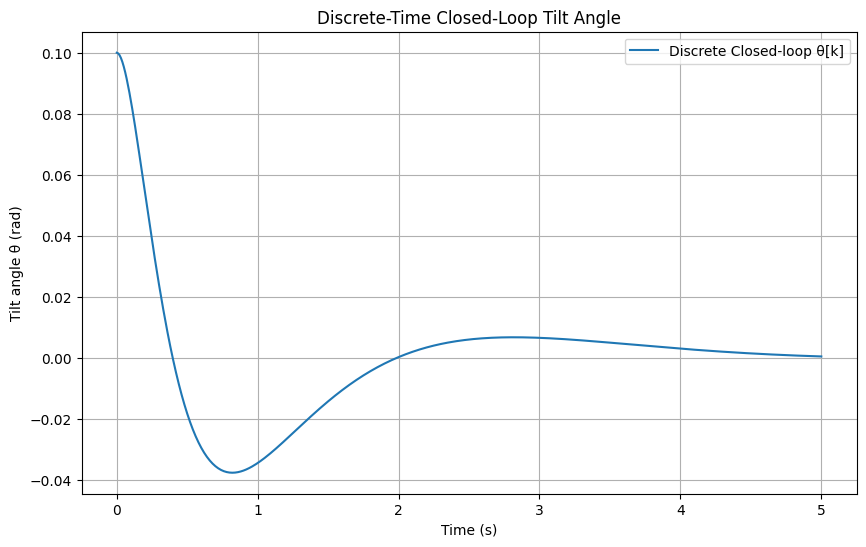

In [9]:
# Simulate discrete-time closed-loop for validation
def simulate_discrete(x0, K_d, Ad, Bd, steps):
    xs = np.zeros((4, steps + 1))
    ts = np.arange(steps + 1) * dt
    xs[:, 0] = x0
    for k in range(steps):
        u_k = -K_d @ xs[:, k]
        xs[:, k + 1] = Ad @ xs[:, k] + (Bd.flatten() * u_k)
    return ts, xs


steps = int(5.0 / dt)
ts, xs = simulate_discrete(x0, K_d, Ad, Bd, steps)

plt.figure(figsize=(10, 6))
plt.plot(ts, xs[0, :], label="Discrete Closed-loop θ[k]")
plt.xlabel("Time (s)")
plt.ylabel("Tilt angle θ (rad)")
plt.title("Discrete-Time Closed-Loop Tilt Angle")
plt.legend()
plt.grid(True)
plt.show()